# 0. Imports

In [1]:
import sys
sys.path.append("../src/")

from utils import mean_std_cross_val_scores, mape

from extrucal.extrusion import throughput_cal

import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, LogisticRegression, Ridge
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import shuffle
from tqdm import tqdm
from xgboost import XGBClassifier, XGBRegressor

import joblib

random.seed(0)

# 1. Dataset Read In and Modification

In [2]:
df = pd.read_csv("../data/dataset_generated_by_extrucal_from_1_rpm.csv")
df

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight,throughput
0,130,7.8,1300,41,234.0,13.0,1,795.947880
1,230,6.9,800,1,184.0,32.2,2,12.391977
2,240,4.8,1100,71,192.0,14.4,2,1289.777079
3,170,5.1,1000,71,102.0,27.2,2,232.970733
4,250,17.5,1100,1,450.0,35.0,1,126.518677
...,...,...,...,...,...,...,...,...
1505275,80,3.2,1000,1,144.0,6.4,2,2.272184
1505276,130,2.6,900,51,234.0,13.0,2,217.158551
1505277,240,7.2,1200,11,384.0,24.0,1,582.806868
1505278,200,18.0,1400,51,120.0,20.0,1,2133.713332


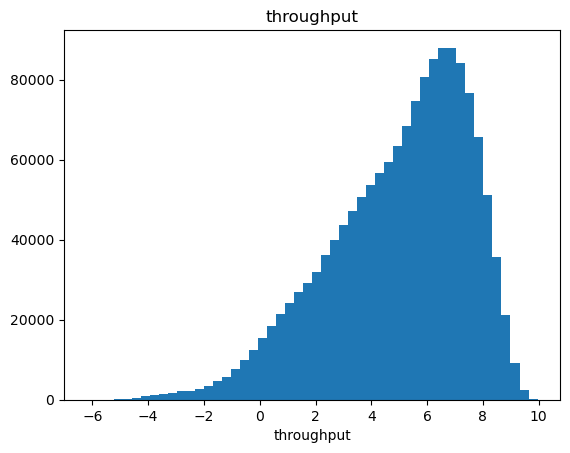

In [5]:
# Checking the distribution of throughput after log transformation
plt.figure()
plt.hist(np.log(df["throughput"]), bins=50)
plt.title("throughput")
plt.xlabel("throughput")
plt.show();

In [6]:
# Apply log-transformation to target
df["log_throughput"] = np.log(df["throughput"])

# 2. Train/Test Split

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df.head()

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight,throughput,log_throughput
740665,210,14.7,1200,51,252.0,12.6,2,3073.421195,8.030547
164740,250,7.5,1100,91,200.0,45.0,2,1552.058046,7.347337
250675,250,12.5,1100,61,450.0,20.0,2,5910.649400,8.684511
1371460,50,2.5,1000,51,70.0,9.0,1,29.545636,3.385936
1356849,170,5.1,900,21,272.0,30.6,2,235.748214,5.462764


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1204224 entries, 740665 to 773630
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   extruder_size    1204224 non-null  int64  
 1   metering_depth   1204224 non-null  float64
 2   polymer_density  1204224 non-null  int64  
 3   rpm              1204224 non-null  int64  
 4   screw_pitch      1204224 non-null  float64
 5   flight_width     1204224 non-null  float64
 6   number_flight    1204224 non-null  int64  
 7   throughput       1204224 non-null  float64
 8   log_throughput   1204224 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 91.9 MB


In [9]:
X_train = train_df.drop(columns=["throughput", "log_throughput"])
y_train = train_df["log_throughput"]

X_test = test_df.drop(columns=["throughput", "log_throughput"])
y_test = test_df["log_throughput"]

# 3. Preparation of Preprocessors

In [10]:
no_log_features = ["extruder_size", "polymer_density", "rpm", "number_flight"]
log_features = ["metering_depth", "screw_pitch", "flight_width"]

In [11]:
no_log_transformer = make_pipeline(
    StandardScaler(),
)

In [12]:
log_transformer = make_pipeline(
    FunctionTransformer(np.log),
    StandardScaler(),
)

In [13]:
preprocessor = make_column_transformer(
    (no_log_transformer, no_log_features),
    (log_transformer, log_features)
)

# 4. Cross-Validation of ML Models

In [14]:
results = {}

In [15]:
mape_scorer = make_scorer(mape, greater_is_better=False)

## 4.1. Baseline Model

In [16]:
pipe_dummy = make_pipeline(preprocessor, DummyRegressor())

In [17]:
results["Dummy"] = mean_std_cross_val_scores(
    pipe_dummy, X_train, y_train, return_train_score=True, scoring="neg_mean_squared_error"
)

In [18]:
pd.DataFrame(results)

,Dummy
fit_time,0.644 (+/- 0.038)
score_time,0.086 (+/- 0.009)
test_score,-6.254 (+/- 0.014)
train_score,-6.254 (+/- 0.003)


## 4.2. ML Models

In [19]:
random_state = 123

pipe_ridge = make_pipeline(
    preprocessor, Ridge(max_iter=2000, random_state=random_state)
)
pipe_lasso = make_pipeline(
    preprocessor, Lasso(max_iter=2000, random_state=random_state)
)
pipe_rf = make_pipeline(
    preprocessor, RandomForestRegressor(random_state=random_state)
)
pipe_xgb = make_pipeline(
    preprocessor, XGBRegressor(random_state=random_state, verbosity=0)
)
pipe_lgbm = make_pipeline(preprocessor, LGBMRegressor(random_state=random_state))
pipe_catb = make_pipeline(
    preprocessor,
    CatBoostRegressor(random_state=random_state, verbose=0, loss_function="RMSE"),
)

In [20]:
models = {
    "ridge": pipe_ridge,
    "lass": pipe_lasso,
    "random_forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catb,
}

In [21]:
%%time

for name, model in tqdm(models.items()):
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring="neg_mean_squared_error"
    )

In [22]:
pd.DataFrame(results)

,Dummy
fit_time,0.644 (+/- 0.038)
score_time,0.086 (+/- 0.009)
test_score,-6.254 (+/- 0.014)
train_score,-6.254 (+/- 0.003)


#### `CatBoost` still perform best

# 5. Evaluation of `CatBoost` Model

In [23]:
%%time

pipe_catb.fit(X_train, y_train)

CPU times: total: 12min 50s
Wall time: 2min 18s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['extruder_size',
                                                   'polymer_density', 'rpm',
                                                   'number_flight']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['metering_depth',
     

## 5.1. Comparison between Prediction and `y_test`

In [24]:
y_pred = np.exp(pipe_catb.predict(X_test))

In [25]:
y_test = np.exp(y_test)

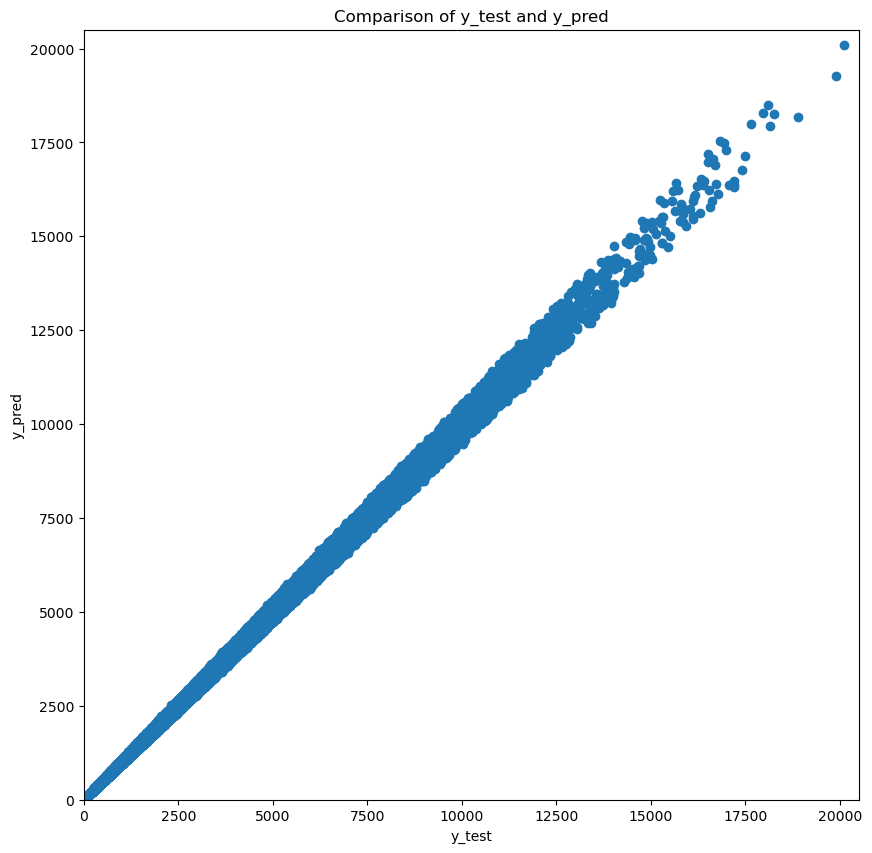

In [26]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.xlim(0, 20500)
plt.ylim(0, 20500)
plt.title("Comparison of y_test and y_pred")
plt.show();

In [27]:
mape(y_test, y_pred)

2.5268867804446273

## 5.2. Comparison with `extrucal` results

In [28]:
extruder_size = []
for i in range(25, 251, 25):
    extruder_size.extend([i] * 10)

metering_depth_percent = [0.05] * 100
polymer_density = [1000] * 100
screw_pitch_percent = [1] * 100
flight_width_percent = [0.1] * 100
number_flight = [1] * 100
rpm = [
    r for r in range(0, 92, 10)
] * 10

In [29]:
df = pd.DataFrame(
    {"extruder_size": extruder_size,
     "metering_depth_percent": metering_depth_percent,
     "polymer_density": polymer_density,
     "screw_pitch_percent": screw_pitch_percent,
     "flight_width_percent": flight_width_percent,
     "number_flight": number_flight,
     "rpm": rpm}
)

df["metering_depth"] = df["extruder_size"] * df["metering_depth_percent"]
df["screw_pitch"] = df["extruder_size"] * df["screw_pitch_percent"]
df["flight_width"] = df["extruder_size"] * df["flight_width_percent"]

new_col_order = [
    "extruder_size", "metering_depth", "polymer_density", 
    "rpm", "screw_pitch", "flight_width", "number_flight", ]

df = df[new_col_order]
df.head()

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight
0,25,1.25,1000,1,25,2.5,1
1,25,1.25,1000,11,25,2.5,1
2,25,1.25,1000,21,25,2.5,1
3,25,1.25,1000,31,25,2.5,1
4,25,1.25,1000,41,25,2.5,1


In [30]:
df["CatBoost_model"] = np.exp(pipe_catb.predict(df))

In [31]:
df["extrucal"] = df.apply(
    lambda row: throughput_cal(
        row["extruder_size"],
        row["metering_depth"],
        row["polymer_density"],
        row["rpm"],
        row["screw_pitch"],
        row["flight_width"],
        int(row["number_flight"])), axis=1
)

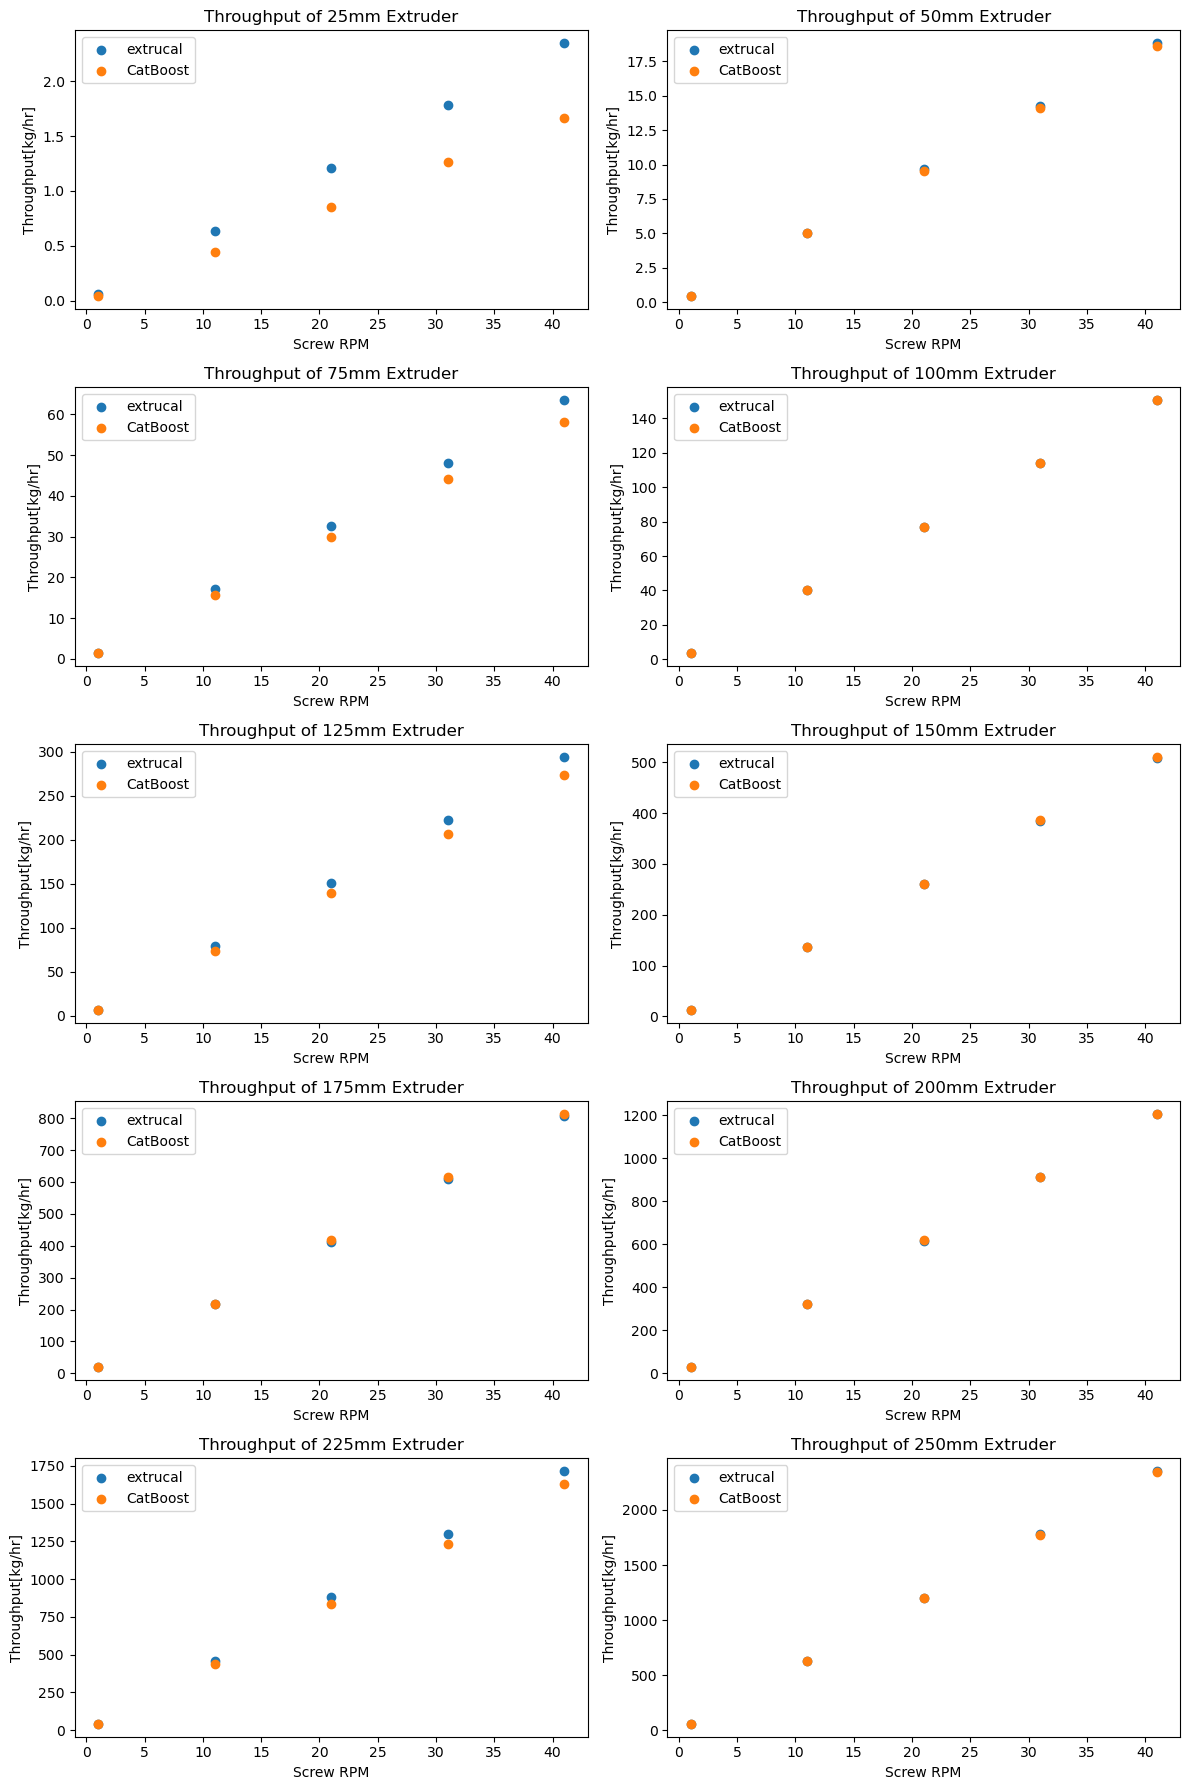

In [32]:
fig, axs = plt.subplots(figsize=(12, 18), nrows=5, ncols=2)
r = 0
c = 0
for size in list(df["extruder_size"].unique()):
    temp = df.query(f"extruder_size == {size}")
    axs[r, c].scatter(temp["rpm"], temp["extrucal"], label="extrucal")
    axs[r, c].scatter(temp["rpm"], temp["CatBoost_model"], label="CatBoost")
    axs[r, c].set_title(f"Throughput of {size}mm Extruder")
    axs[r, c].set_xlabel("Screw RPM")
    axs[r, c].set_ylabel("Throughput[kg/hr]")
    axs[r, c].legend()
    if c < 1:
        c += 1
    else:
        r += 1
        c = 0
plt.tight_layout()
plt.show();

#### The throughput prediction for very low screw RPM (i.e. 1) shows a bit off values"

In [33]:
joblib.dump(pipe_catb, "../models/from_one_catb_model.pkl")

['../models/from_one_catb_model.pkl']